<a href="https://colab.research.google.com/github/judem-21/Transformers-Implementation/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [18]:
import torch
import torch.nn as nn
import numpy as np

##Transformer Model

#####Attention Block
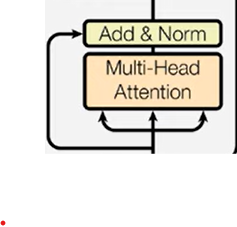

In [25]:
class SelfAttention(nn.Module):
  def __init__(self,embed_size,num_heads):
    super(SelfAttention,self).__init__()
    self.embed_size=embed_size
    self.num_heads=num_heads
    self.head_dim=embed_size//num_heads

    assert (self.num_heads*self.head_dim==self.embed_size), "Embedding size needs to be divisible by heads"

    self.values=nn.Linear(self.embed_dim,self.embed_dim,bias=False)
    self.keys=nn.Linear(self.embed_dim,self.embed_dim,bias=False)
    self.queries=nn.Linear(self.embed_dim,self.embed_dim,bias=False)
    self.fc_out=nn.Linear(self.embed_size,self.embed_size)

  def forward(self,value,key,query,mask=None):
    N=queries.shape[0] #Number of examples per batch
    values=self.values(value)
    keys=self.keys(key)
    queries=self.queries(query)
    value_len,key_len,query_len=values.shape[1],keys.shape[1],queries.shape[1] #Source/Target sentence length

    values=values.reshape(N,value_len,self.num_heads,self.head_dim)
    keys=keys.reshape(N,key_len,self.num_heads,self.head_dim)
    queries=queries.reshape(N,query_len,self.num_heads,self.head_dim)

    #query_dim: (N,query_len,num_heads,head_dim)
    #key_dim: (N,key_len,num_heads,head_dim)
    #value_dim: (N,value_len,num_heads,head_dim)
    #energy (softmax scores) dim: (N,num_heads,query_dim,key_dim)

    energy_scores=torch.einsum("nqhd,nkhd->nhqk",[queries,keys])

    if mask is not None:
      energy_scores=energy_scores.masked_fill(mask==0,float("-inf"))

    attention_scores=torch.softmax(energy_scores/(self.embed_size**(1/2)),dim=3)
    #attention_score dim: (N,num_heads,query_len,key_len)
    #finl_output dim: (N,query_len,num_heads,head_dim)
    #Key_length is always equal to Value_length (number of keys = number of values)
    out=torch.einsum("nhqk,nkhd->nqhd",[attention_scores,values])
    out=out.reshape(N,query_len,self.embed_size)
    out=self.fc_out(out)
    return out+query

#####Transformer Block
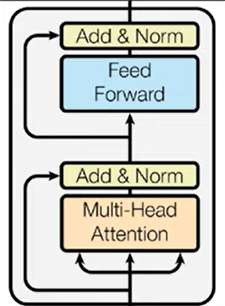

In [26]:
class TransformerBlock(nn.Module):
  def __init__(self,embed_size,num_heads,dropout,forward_expansion):
    super(TransformerBlock,self).__init__()
    self.attention=SelfAttention(embed_size,num_heads)
    self.embed_size,self.num_heads=embed_size,num_heads
    self.dropout=nn.Dropout(dropout)
    self.norm1=nn.LayerNorm(embed_size)
    self.norm2=nn.LayerNorm(embed_size)
    self.feed_forward=nn.Sequential(nn.Linear(embed_size,forward_expansion*embed_size)
    ,nn.ReLU(),nn.Linear(forward_expansion*embed_size,embed_size))

  def forward(self,value,key,query,mask):
    #attention=self.attention(embedding,mask)
    x=self.dropout(self.norm1(self.attention(value,key,query)))
    forward=self.feed_forward(x)
    out=self.dropout(self.norm2(forward+x))
    return out

#####Encoder
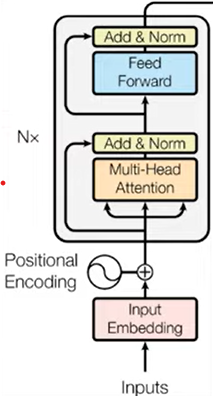

In [27]:
class Encoder(nn.Module):
  def __init__(self,source_vocab_size,embed_size,num_layers,num_heads,device,forward_expansion,dropout,max_length):
    super(Encoder,self).__init__()
    self.embed_size=embed_size
    self.embedding=nn.Embedding(source_vocab_size,embed_size)
    self.device=device
    self.positional_encoding=nn.Embedding(max_length,embed_size)
    self.layers=nn.ModuleList([TransformerBlock(embed_size,num_heads,dropout,forward_expansion)
    for _ in range(num_layers)])
    self.dropout=nn.Dropout(dropout)

  def forward(self,x,source_mask):
    N,seq_length=x.shape
    positions=torch.arange(0,seq_length).expand(N,seq_length).to(self.device)
    out=self.dropout(self.embedding(x)+self.positional_encoding(positions))

    for layer in self.layers:
      out=layer(out,out,out,mask=source_mask)
    return out

#####Decoder Block
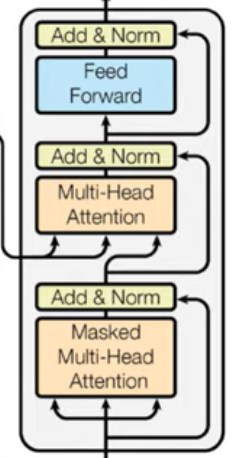

In [28]:
class DecoderBlock(nn.Module):
  def __init__(self,embed_size,num_heads,forward_expansion,dropout,device):
    super(DecoderBlock,self).__init__()
    self.attention=SelfAttention(embed_size,num_heads)
    self.norm=nn.LayerNorm(embed_size)
    self.transformer_block=TransformerBlock(embed_size,num_heads,dropout,forward_expansion)
    self.dropout=nn.Dropout(dropout)
    #self.layers=nn.Mo

  def forward(self,x,value,key,source_mask,target_mask):
    x=self.dropout(self.norm(self.attention(x,x,x,mask=target_mask)))
    out=self.transformer_block(value,key,x,mask=source_mask)
    return out

#####Decoder
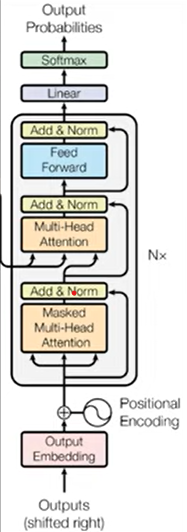

In [29]:
class Decoder(nn.Module):
  def __init__(self,embed_size,num_heads,num_layers,target_vocab_size,
               forward_expansion,dropout,device,max_length):
    super(Decoder,self).__init__()
    self.device=device
    self.word_embeddings=nn.Embeddings(target_vocab_size,embed_size)
    self.positional_encoding=nn.Embeddings(max_length,embed_size)
    self.layers=nn.ModuleList([DecoderBlock(embed_size,num_heads,forward_expansion,dropout,device)
    for _ in range(num_layers)])
    self.fc_out=nn.Linear(embed_size,target_vocab_size)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x,encoder_out,source_mask,target_mask):
    N,seq_length=x.shape
    positions=torch.arange(0,seq_length).expand(N,seq_length).to(self.device)
    x=self.dropout(self.word_embeddings(x)+self.positional_encoding(positions))

    for layer in self.layers:
      x=layer(x,encoder_out,encoder_out,source_mask,target_mask)
    out=self.fc_out(x)
    return out

#####Transformer Ensemble
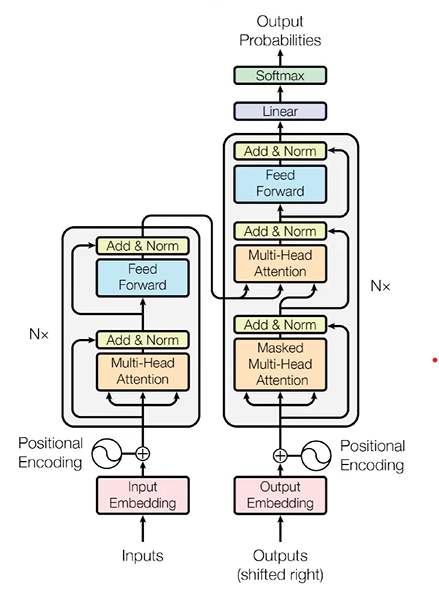

In [30]:
class Transformer(nn.Module):
  def __init__(self,num_layers,source_vocab_size,target_vocab_size,
               source_pad_idx,target_pad_idx,forward_expansion=6,
               dropout=0,max_length=100,device='cuda',num_heads=8,embed_size=256):
    super(Transformer,self).__init__()
    self.encoder=Encoder(source_vocab_size,embed_size,num_layers,
                         num_heads,device,forward_expansion,dropout,
                         max_length)
    self.decoder=Decoder(embed_size,num_heads,num_layers,
                         target_vocab_size,forward_expansion,dropout,
                         device,max_length)
    self.device=device
    self.source_pad_idx=source_pad_idx
    self.target_pad_idx=target_pad_idx

  def make_source_mask(self,source):
    source_mask=(source!=self.source_pad_idx).unsqueeze(1).unsqueeze(2)
    #dim source mask: (N,1,1,source_length)

    return source_mask.to(self.device)

  def make_target_mask(self,target):
    N,target_len=target.shape
    target_mask=torch.tril(torch.ones((target_len,target_len))).expand(N,1,target_len,target_len)
    return target_mask.to(self.device)

  def forward(self,source_seq,target_seq):
    source_mask=self.make_source_mask(source_seq)
    target_mask=self.make_target_mask(target_seq)
    encoder_out=self.encoder(source_seq,source_mask)
    out=self.decoder(target_seq,encoder_out,source_mask,target_mask)
    return out